In [ ]:
# for running the code in the notebook
#!pip install git+https://github.com/omuto/RVINN
#!git clone https://github.com/omuto/RVINN # clone the repo to get the data
#!cd RVINN/demo

In [1]:
import rvinn as rv

import os
import torch
import numpy as np
import matplotlib.pyplot as plt

# default device is CPU 
device = torch.device('cpu')

# set seed 
seed = 0
torch.manual_seed(seed)

# Set the number of threads to use in PyTorch 
# Setting a single thread explicitly is recommended in executing array jobs on HPC clusters
torch.set_num_threads(1)

In [2]:
Sp_df, Un_df, observed_timepoints = rv.ut.load_mcf7_data('E2') # E2 or TAM

In [ ]:
gene = "ASB13"
save_dir = rv.ut.create_save_directory(gene, output_dir_name="E2")
print(f"results will be saved in {save_dir}")
replicates = 3 
Sp_star, Un_star = rv.ut.load_target(gene, Sp_df, Un_df, replicates)
t_star, t_f = rv.ut.load_observation_period(observed_timepoints)

In [ ]:
# empty arrays to store the results
Sp_e = np.empty((len(t_f),0))
Un_e = np.empty((len(t_f),0))
k1_e = np.empty((len(t_f),0))
k2_e = np.empty((len(t_f),0))
k3_e = np.empty((len(t_f),0))
Sp_t_e = np.empty((len(t_f),0))
Un_t_e = np.empty((len(t_f),0))
k1_t_e = np.empty((len(t_f),0))
k2_t_e = np.empty((len(t_f),0))
k3_t_e = np.empty((len(t_f),0))

# Training and prediction 10 times
for i in range(1, 11):
    print(f"Model_{i}")
    model = rv.model.Model(
                device=device,
                t_train=t_star,
                spliced_train=Sp_star,
                unspliced_train=Un_star,
                t_f=t_f,
                init_steady=True,
                init_data=True
                )
    model.train()
    Sp, Un, k1, k2, k3, Sp_t, Un_t, k1_t, k2_t, k3_t = model.predict(t_f)

    Sp_e = np.append(Sp_e, Sp, axis=1)
    Un_e = np.append(Un_e, Un, axis=1)
    k1_e = np.append(k1_e, k1, axis=1)
    k2_e = np.append(k2_e, k2, axis=1)
    k3_e = np.append(k3_e, k3, axis=1)
    Sp_t_e = np.append(Sp_t_e, Sp_t, axis=1)
    Un_t_e = np.append(Un_t_e, Un_t, axis=1)
    k1_t_e = np.append(k1_t_e, k1_t, axis=1)
    k2_t_e = np.append(k2_t_e, k2_t, axis=1)
    k3_t_e = np.append(k3_t_e, k3_t, axis=1)

    print("the number of cpu threads: {}".format(torch.get_num_threads()))

    #delete model
    del model

    # Getting all memory using os.popen()
    total_memory, used_memory, free_memory = map(int, os.popen('free -t -m').readlines()[-1].split()[1:])

    # Memory usage
    print("RAM memory % used:", round((used_memory/total_memory) * 100, 2))

rv.ut.save_results(gene, save_dir, Sp_e, Un_e, k1_e, k2_e, k3_e, Sp_t_e, Un_t_e, k1_t_e, k2_t_e, k3_t_e)

In [5]:
Sp_rvinn, Un_rvinn, alpha, beta, gamma = rv.ut.load_avg_results(gene, save_dir)

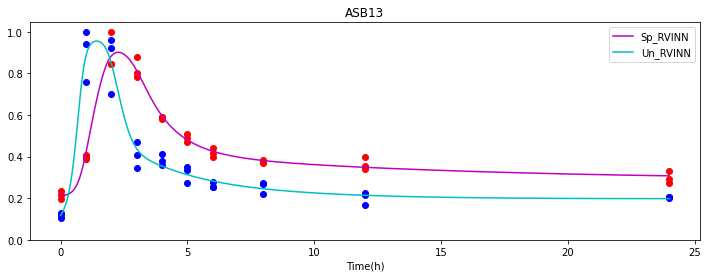

In [6]:
plt.figure(figsize=(12, 4))
plt.plot(t_star, Sp_star, "ro") # observed data
plt.plot(t_star, Un_star, "bo") # observed data
plt.plot(t_f, Sp_rvinn, "m-", label="Sp_RVINN")
plt.plot(t_f, Un_rvinn, "c-", label="Un_RVINN")
plt.xlabel("Time(h)")
plt.ylim(0, )
plt.title(gene)
plt.legend()

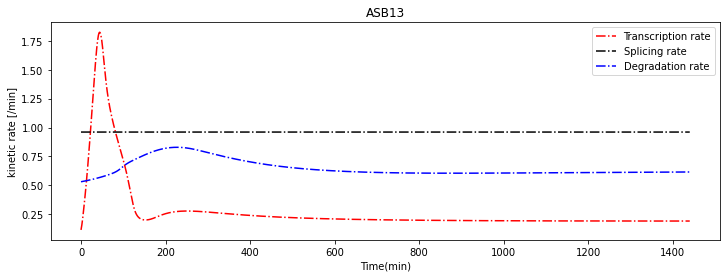

In [9]:
plt.figure(figsize=(12, 4))
plt.plot(alpha, "r-.", label="Transcription rate")
plt.plot(beta, "k-.", label="Splicing rate")
plt.plot(gamma, "b-.", label="Degradation rate")
plt.xlabel("Time(min)")
plt.ylabel("kinetic rate [/min]")
plt.title(gene)
plt.legend()